In [64]:
from pymonntorch import NeuronGroup, SynapseGroup, NeuronDimension, Recorder, Behavior, EventRecorder
import random
from conex import (
    Neocortex,
    prioritize_behaviors,
)
from conex.behaviors.neurons import (
    SimpleDendriteStructure,
    SimpleDendriteComputation,
    LIF,
    SpikeTrace,
    NeuronAxon,
    Fire,
    KWTA,
    ActivityBaseHomeostasis,
    VoltageBaseHomeostasis,
)
from conex.behaviors.synapses import (
    SynapseInit,
    WeightInitializer,
    SimpleDendriticInput,
    LateralDendriticInput,
    SimpleSTDP,
    WeightClip
)


import torch
import matplotlib.pyplot as plt
from scipy.stats import poisson



In [65]:
##################################################
# parameters
##################################################
DEVICE = "cpu"
DTYPE = torch.float32
DT = 0.1
IT = 2000

TAU_S = 5

# input layer
LIF_INPUT1 = {"R":0 , "threshold":0.5 , "tau":0 , "v_reset":0 , "v_rest":0, "v_init": 0}
LIF_INPUT = LIF_INPUT1

# output layer
LIF_OUTPUT1 = {"R":5 , "threshold":-37 , "tau":20 , "v_reset":-65 , "v_rest":-67, "init_v":"normal(-50,3)"}
LIF_OUTPUT2 = {"R":5 , "threshold":-66 , "tau":10 , "v_reset":-68 , "v_rest":-67, "init_v":"normal(-68,3)"}

LIF_OUTPUT = LIF_OUTPUT1

# KWTA
K = 1

# LAT. INH.
LAT_COEF = 50

# ACT BASED HOMOSTASIS
WIN_S = 200
ACT_R = 10
UPD_R = 1
DEC_R = 0.85

# VOLT BASED HOMOSTASIS
TARGET_V = -37
MAX_T = -34
MIN_T = -50
ETA_IP = 0.001


# STDP
A_PLUS = 30
A_MINUS = 20

# Patterns
t=20 
n = 10
c = 7
#------------------------------------------------------------
P1 = [([(1 if random.uniform(0,1) <= poisson.pmf(k=i,mu=t/2)*c else 0) for _ in range(n)]+[0]*4*n) for i in range(t)] 
P2 = [([0]*n+[(1 if random.uniform(0,1) <= poisson.pmf(k=i,mu=t/2)*c else 0) for _ in range(n)]+[0]*3*n) for i in range(t)] 
P3 = [([0]*2*n+[(1 if random.uniform(0,1) <= poisson.pmf(k=i,mu=t/2)*c else 0) for _ in range(n)]+[0]*2*n) for i in range(t)] 
P4 = [([0]*3*n+[(1 if random.uniform(0,1) <= poisson.pmf(k=i,mu=t/2)*c else 0) for _ in range(n)]+[0]*n) for i in range(t)] 
P5 = [([0]*4*n+[(1 if random.uniform(0,1) <= poisson.pmf(k=i,mu=t/2)*c else 0) for _ in range(n)]) for i in range(t)]
P6 = [[0 for _ in range(5*n)] for _ in range(t)]

In [66]:
class LateralInhibition(Behavior):
    def initialize(self, ng: NeuronGroup):
        self.coef = self.parameter("coef",default=None)
    def forward(self, ng: NeuronGroup):
        tmp = torch.logical_not(ng.spikes).long()
        tmp *= self.coef
        tmp *= -1
        ng.I += tmp

In [67]:
class ForcedNeuron(Behavior):

    def __init__(
        self,
        R,
        threshold,
        tau,
        v_reset,
        v_rest,
        *args,
        init_v=None,
        init_s=None,
        **kwargs
    ):
        super().__init__(
            *args,
            R=R,
            tau=tau,
            threshold=threshold,
            v_reset=v_reset,
            v_rest=v_rest,
            init_v=init_v,
            init_s=init_s,
            **kwargs
        )

    def initialize(self, neurons):
        self.add_tag(self.__class__.__name__)

        neurons.R = self.parameter("R", default=0, required=False)
        neurons.tau = self.parameter("tau", default=0, required=False)
        neurons.threshold = self.parameter("threshold", default=0.5, required=False)
        neurons.v_reset = self.parameter("v_reset", default=0, required=False)
        neurons.v_rest = self.parameter("v_rest", default=0, required=False)
        neurons.v = self.parameter("init_v", neurons.vector())

        self.pat1 = self.parameter("pat1")
        self.pat2 = self.parameter("pat2")
        self.pat3 = self.parameter("pat3")
        self.pat4 = self.parameter("pat4")
        self.pat5 = self.parameter("pat5")
        self.pat6 = self.parameter("pat6")
        neurons.spikes = self.parameter("init_s", neurons.v >= neurons.threshold)

        neurons.spiking_neuron = self
        self.timeInterval = self.parameter("timeInterval")


    def Fire(self, neurons):
        neurons.spikes = neurons.v >= neurons.threshold
        neurons.v[neurons.spikes] = neurons.v_reset

    def forward(self, neurons):
        neurons.v = self.getPat(neurons.iteration,self.timeInterval)
    
    def getPat(self,t,c):
        if ((t//c) % 10 == 0):
            return torch.tensor(self.pat1[t%self.timeInterval], dtype=torch.float32)
        elif ((t//c) % 10 == 2):
            return torch.tensor(self.pat2[t%self.timeInterval], dtype=torch.float32)
        elif ((t//c) % 10 == 4):
            return torch.tensor(self.pat3[t%self.timeInterval], dtype=torch.float32)
        elif ((t//c) % 10 == 6):
            return torch.tensor(self.pat4[t%self.timeInterval], dtype=torch.float32)
        elif ((t//c) % 10 == 8):
            return torch.tensor(self.pat5[t%self.timeInterval], dtype=torch.float32)
        else:
            return torch.tensor(self.pat6[t%self.timeInterval], dtype=torch.float32)
    

In [68]:
# NET
net = Neocortex(dt=DT, device=DEVICE, dtype=DTYPE)

In [69]:
# INPUT LAYER
behavior_in = {
        10: ForcedNeuron(
                R=LIF_INPUT["R"],
                threshold=LIF_INPUT["threshold"],
                tau=LIF_INPUT["tau"],
                v_reset=LIF_INPUT["v_reset"],
                v_rest=LIF_INPUT["v_rest"],
                pat1 = P1, pat2 = P2, pat3 = P3, pat4 = P4, pat5 = P5, pat6 = P6,
                timeInterval=t
                ),
        20: Fire(),
        30: SpikeTrace(tau_s=TAU_S),
        40: NeuronAxon(),
        100: EventRecorder(tag="pop1_evrec", variables=["spikes"])
}


pop_inp = NeuronGroup(
    net=net,
    size=len(P1[0]),
    behavior=behavior_in,
)

In [70]:
# OUTPUT LAYER
behavior_out=prioritize_behaviors(
        [
            SimpleDendriteStructure(),
            SimpleDendriteComputation(),
            LIF(
                R=LIF_OUTPUT["R"],
                threshold=LIF_OUTPUT["threshold"],
                tau=LIF_OUTPUT["tau"],
                v_reset=LIF_OUTPUT["v_reset"],
                v_rest=LIF_OUTPUT["v_rest"],
                init_v=LIF_OUTPUT["init_v"]
            ),
            SpikeTrace(tau_s=TAU_S),
            KWTA(k=K),
            Fire(),
            NeuronAxon(),
            ActivityBaseHomeostasis(window_size=WIN_S, activity_rate=ACT_R, updating_rate=UPD_R, decay_rate=DEC_R),
            # VoltageBaseHomeostasis(target_voltage=TARGET_V, max_ta=MAX_T, min_ta=MIN_T, eta_ip=ETA_IP),
        ]
    )

behavior_out[1000] = Recorder(tag="pop2_rec", variables=["v", "I"])
behavior_out[1001] = EventRecorder(tag="pop2_evrec", variables=["spikes"])
# behavior_out[259] = LateralInhibition(coef=LAT_COEF)


pop_out = NeuronGroup(
    net=net,
    size=7,
    behavior=behavior_out
)

In [71]:
# SYN
behavior_syn=prioritize_behaviors(
        [
            SynapseInit(),
            WeightInitializer(mode="normal(2,0.2)"),
            SimpleDendriticInput(current_coef=1000),
            SimpleSTDP(a_plus=A_PLUS, a_minus=A_MINUS),
            WeightClip(w_max=10,w_min=0)
        ])
behavior_syn[1000] = Recorder(tag="syn_rec", variables=["weights"])
syn_inp_out = SynapseGroup(
    net=net,
    src=pop_inp,
    dst=pop_out,
    tag="Proximal",
    behavior=behavior_syn,
)

syn_lateral = SynapseGroup(net = net, src = pop_out, dst = pop_out,tag = "Proximal, inh", behavior=prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(weights=torch.Tensor([1, 0, 1, 0, 1, 0, 1, 0, 1]).view(1, 1, 1, 1, 9)),
    LateralDendriticInput(inhibitory=True, current_coef=55),
]))

net.initialize()
net.simulate_iterations(IT)


Network['Neocortex'](Neurons: tensor(57)|2 groups, Synapses: tensor(399)|2 groups){1:TimeResolution(dt=0.1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](50){10:ForcedNeuron(R=0,tau=0,threshold=0.5,v_reset=0,v_rest=0,init_v=None,init_s=None,pat1=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

2848.2630252838135

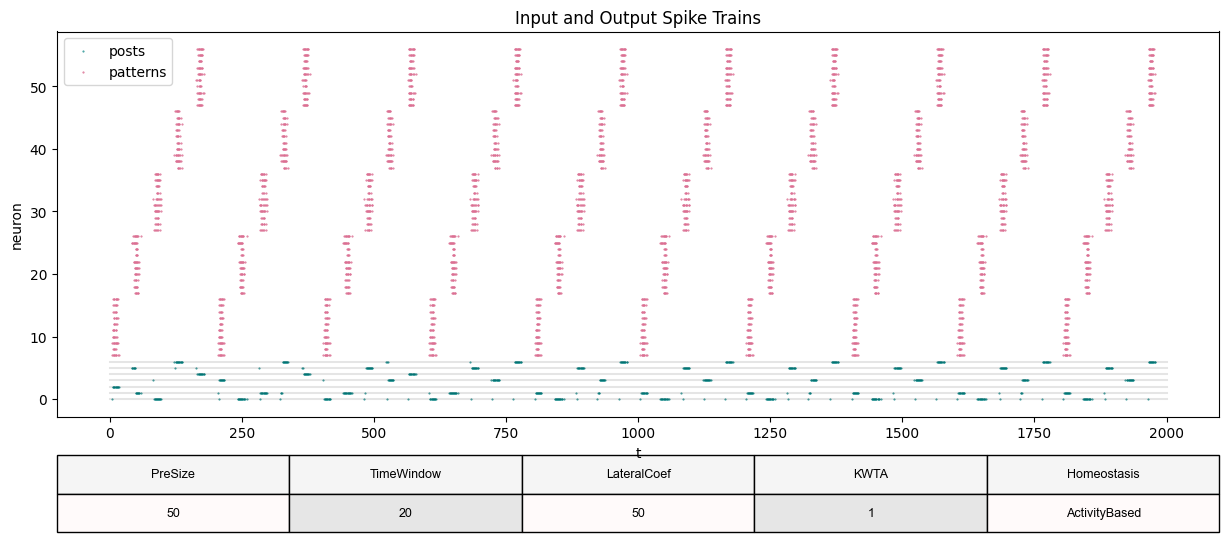

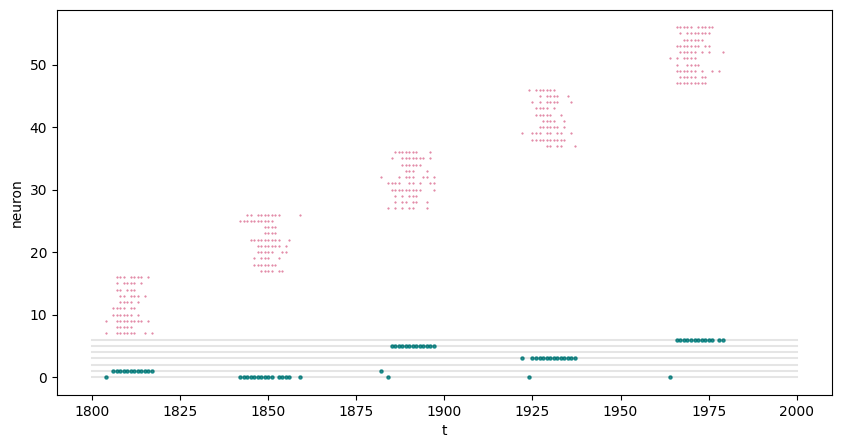

In [72]:
plt.figure().set_size_inches(15,5)
plt.scatter(net["spikes", 1][:,0], net["spikes", 1][:,1],s=0.25, c="teal",alpha=0.8 ,label="posts")

plt.scatter(net["spikes", 0][:,0], net["spikes", 0][:,1]+pop_out.size, s=0.25, c="palevioletred",alpha=1, label="patterns")
plt.xlabel("t")
plt.ylabel("neuron")
plt.legend()
plt.title("Input and Output Spike Trains")
for i in range(pop_out.size):
        plt.plot([0, IT], [i, i], color="black", alpha=0.1)
FONT = "arial"
parameters = ["PreSize", "TimeWindow", "LateralCoef", "KWTA","Homeostasis"]
values = [pop_inp.size, t, LAT_COEF, 1,"ActivityBased"]
table_data = [parameters, values]
table = plt.table(cellText = table_data, cellLoc = "center", loc = "bottom", bbox = [0, -0.3, 1, 0.2])
table.scale(0.8, 0.8)
table.auto_set_font_size(False)
table.set_fontsize(9)
for i in range(len(parameters)):
        table[(0, i)].set_facecolor("whitesmoke")
        table[(0, i)].set_text_props(color = 'black', fontfamily = FONT)

for i in range(len(values)):
        table[(1, i)].set_facecolor("snow" if i % 2 == 0 else '#e6e6e6')
        table[(1, i)].set_text_props(fontfamily = FONT)

plt.show()


spike = net['pop1_evrec',0]['spikes',0][:,1]
time = net['pop1_evrec',0]['spikes',0][:,0]


showafter=1800

plt.figure().set_size_inches(10,5)
plt.scatter(time[time>showafter],spike[time>showafter]+pop_out.size,s=0.25,c='palevioletred')

spike = net['pop2_evrec',0]['spikes',0][:,1]
time = net['pop2_evrec',0]['spikes',0][:,0]

for i in range(pop_out.size):
        plt.plot([showafter, IT], [i, i], color="black", alpha=0.1)

plt.xlabel("t")
plt.ylabel("neuron")
plt.scatter(time[time>showafter],spike[time>showafter],s=5,c='teal', alpha=0.8)
